# Classification of Faces

In this excercise, we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". The data is from a random sample of 8 persons of the OXFORD VGG Face dataset, more information here: http://www.robots.ox.ac.uk/~vgg/data/vgg_face/.

## Downloading of Data

You can download the data using the following code:

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [2]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1","8_faces_train_and_valid.hdf5")

In [3]:
import h5py
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces'][()]
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces'][()]
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces'][()]
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces'][()]
print(Y_valid.shape, X_valid.dtype)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,) float64


250


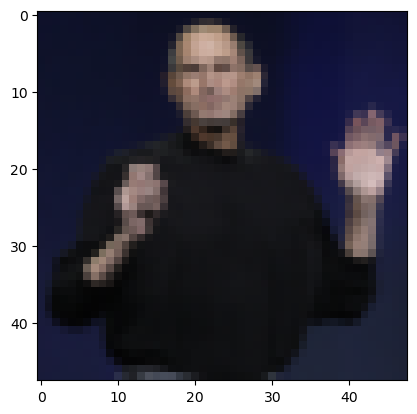

In [4]:
n = 0 #Miranda Cosgrove
n = 1 #Chris Martin (singer)
n = 2 #Emma Stone (actress)
n = 3 #Jamie Foxx (actor)
n = 4 #Steve Jobs (entrepreneur)
n = 5 #Zac Efron (actor)
n = 6 #Sandra Oh (actress)
n = 7 #Taryn Manning (actress)
n = 4
idx = np.reshape(np.where(Y_train[0:len(Y_train)]==n),(250))
print(len(Y_train[idx]))
plt.imshow(np.asarray(X_train[idx][0],dtype="uint8"))

In [5]:
#Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
  urllib.request.urlretrieve("https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1","8_faces_test.hdf5")
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces'][()]
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces'][()]
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [6]:
print(np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test))
X_train /= 255
X_valid /= 255
X_test /= 255

0.0 255.0 0.0 255.0


## a) Training an CNN from scratch

Train a model (as shown below) from scratch, using the training data for training and the validation data for validation. For all activations in the hidden layer use the 'ReLU', for the last layer use softmax. Use 3x3 convolutions and use padding = same.

* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy. 
* Calculate the accuracy on the test set (you should reach an accuracy of about 0.54)
* Calculate the confusion matrix
* Have a look at missclassified examples

Image of the network:
https://github.com/ioskn/mldl_htwg/blob/master/uebungen/dl_cnn_faces_net.png

In [7]:
# Define our new model
# Same means "Zero Padding!"
model = Sequential()
model.add(Conv2D(15, kernel_size=(3, 3), input_shape=(48, 48, 3), name='conv2d_4', padding="same"))
model.add(Activation('relu', name='activation_5'))
model.add(Conv2D(15, kernel_size=(3, 3), input_shape=(48, 48, 3), name='conv2d_5', padding="same"))
model.add(Activation('relu', name='activation_6'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2', padding="same"))
model.add(Conv2D(30, kernel_size=(3, 3), input_shape=(24, 24, 3), name='conv2d_6', padding="same"))
model.add(Activation('relu', name='activation_7'))
model.add(Conv2D(30, kernel_size=(3, 3), input_shape=(24, 24, 3), name='conv2d_7', padding="same"))
model.add(Activation('relu', name='activation_8'))
model.add(MaxPooling2D(pool_size=(4, 4), name='max_pooling2d_3', padding="same"))
model.add(Flatten(name='flatten_2'))
model.add(Dense(300, name='dense_2'))
model.add(Activation('relu', name='activation_9'))
model.add(Dropout(0.2, name="dropout_1"))
model.add(Dense(8, name='dense_3', activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 15)        420       
                                                                 
 activation_5 (Activation)   (None, 48, 48, 15)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 15)        2040      
                                                                 
 activation_6 (Activation)   (None, 48, 48, 15)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 15)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 30)        4080      
                                                        

In [8]:
# Compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Train it
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
63/63 [==============================] - 7s 79ms/step - loss: 1.9813 - accuracy: 0.2130 - val_loss: 1.8522 - val_accuracy: 0.3075
Epoch 2/10
63/63 [==============================] - 4s 64ms/step - loss: 1.6962 - accuracy: 0.3625 - val_loss: 1.6486 - val_accuracy: 0.3925
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 1.4818 - accuracy: 0.4600 - val_loss: 1.4682 - val_accuracy: 0.4175
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 1.2899 - accuracy: 0.5260 - val_loss: 1.3775 - val_accuracy: 0.5100
Epoch 5/10
63/63 [==============================] - 2s 39ms/step - loss: 1.1215 - accuracy: 0.5985 - val_loss: 1.3525 - val_accuracy: 0.5200
Epoch 6/10
63/63 [==============================] - 4s 64ms/step - loss: 0.9736 - accuracy: 0.6570 - val_loss: 1.3154 - val_accuracy: 0.5175
Epoch 7/10
63/63 [==============================] - 3s 50ms/step - loss: 0.7481 - accuracy: 0.7450 - val_loss: 1.2593 - val_accuracy: 0.5625
Epoch 8/10
63

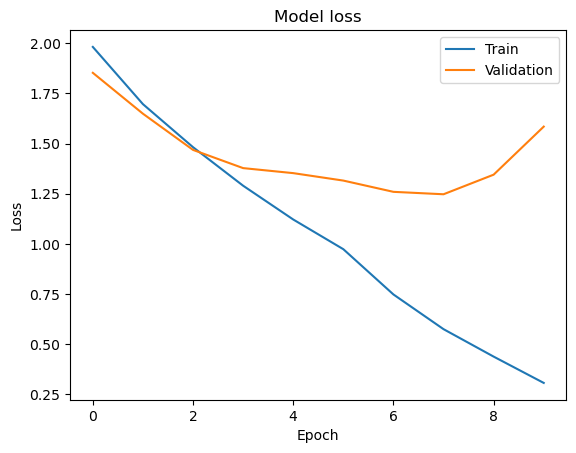

In [10]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

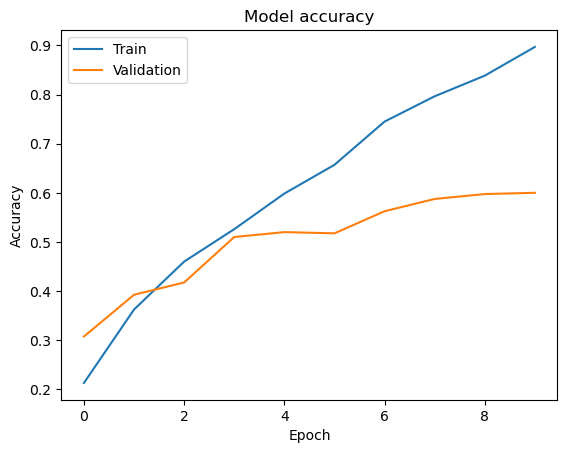

In [11]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the test set to get loss and accuracy
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 0s 21ms/step - loss: 1.3838 - accuracy: 0.6275
Test Loss: 1.3837945461273193
Test Accuracy: 0.6274999976158142


13/13 [==============================] - 1s 18ms/step


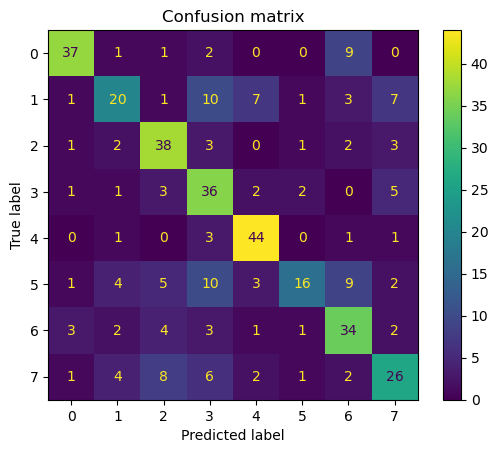

In [13]:
# from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(X_test)
c = confusion_matrix(Y_test, np.argmax(Y_pred, axis=1))
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()

## b) Training using transfer learning
In transfer learning you use an existing trained model with given weights trained on a different task. You then add a few layers yourself and only train them. The model you add should look like:

```
my_dense1 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense2 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense3 (Dense)            (None, 100)               51300     
_________________________________________________________________
my_dense4 (Dense)            (None, 8)                 808       
```

Use the following code as a starting point:

In [14]:
from keras.applications import VGG16
img_height = img_width = 48
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))

In [15]:
fc1 = base_model.output
fc1 = Flatten()(fc1)

fc1 = Dense(512, activation="relu", name="my_dense1")(fc1)
fc1 = Dense(512, activation="relu", name="my_dense2")(fc1)
fc1 = Dense(100, activation="relu", name="my_dense3")(fc1)
fc1 = Dense(8, activation='softmax', name='my_dense4')(fc1)

model_trans = tf.compat.v1.keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras
model_trans.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [16]:
#base_model.summary()
for layer in model_trans.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False
      
model_trans.summary()

my_dense1
my_dense2
my_dense3
my_dense4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPool

In [17]:
# Compile transfer model
model_trans.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [18]:
# And train
history_trans = model_trans.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
63/63 [==============================] - 39s 586ms/step - loss: 1.7173 - accuracy: 0.3490 - val_loss: 1.5199 - val_accuracy: 0.4425
Epoch 2/10
63/63 [==============================] - 31s 497ms/step - loss: 1.2883 - accuracy: 0.5395 - val_loss: 1.3180 - val_accuracy: 0.5300
Epoch 3/10
63/63 [==============================] - 32s 512ms/step - loss: 1.0940 - accuracy: 0.6060 - val_loss: 1.2737 - val_accuracy: 0.5425
Epoch 4/10
63/63 [==============================] - 35s 555ms/step - loss: 0.8797 - accuracy: 0.6975 - val_loss: 1.4548 - val_accuracy: 0.5425
Epoch 5/10
63/63 [==============================] - 35s 561ms/step - loss: 0.7280 - accuracy: 0.7450 - val_loss: 1.4205 - val_accuracy: 0.5525
Epoch 6/10
63/63 [==============================] - 29s 458ms/step - loss: 0.5833 - accuracy: 0.7880 - val_loss: 1.3242 - val_accuracy: 0.5900
Epoch 7/10
63/63 [==============================] - 29s 465ms/step - loss: 0.3992 - accuracy: 0.8650 - val_loss: 1.4866 - val_accuracy: 0.5625

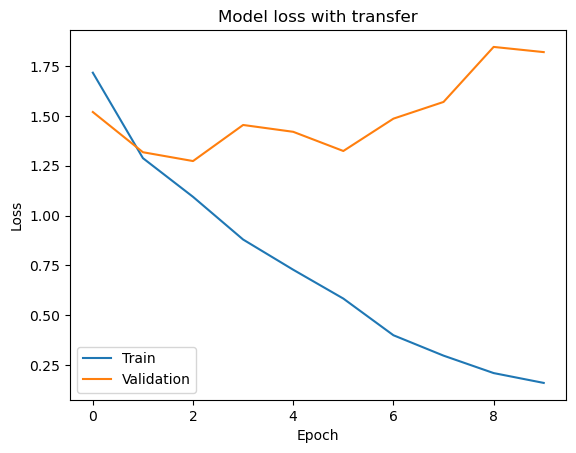

In [19]:
plt.plot(history_trans.history['loss'], label='Train')
plt.plot(history_trans.history['val_loss'], label='Validation')
plt.title('Model loss with transfer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

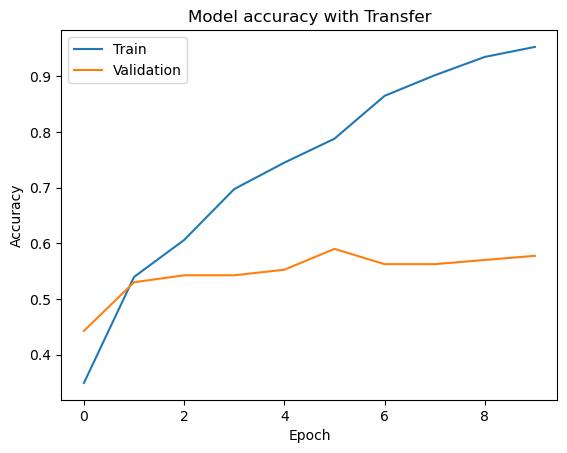

In [20]:
plt.plot(history_trans.history['accuracy'], label='Train')
plt.plot(history_trans.history['val_accuracy'], label='Validation')
plt.title('Model accuracy with Transfer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Do the same analysis as in a) above. You should get an accuracy of approx 0.61

In [21]:
# Evaluate the model on the test set to get loss and accuracy
loss, accuracy = model_trans.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 5s 380ms/step - loss: 1.5618 - accuracy: 0.6200
Test Loss: 1.561766505241394
Test Accuracy: 0.6200000047683716


13/13 [==============================] - 0s 15ms/step


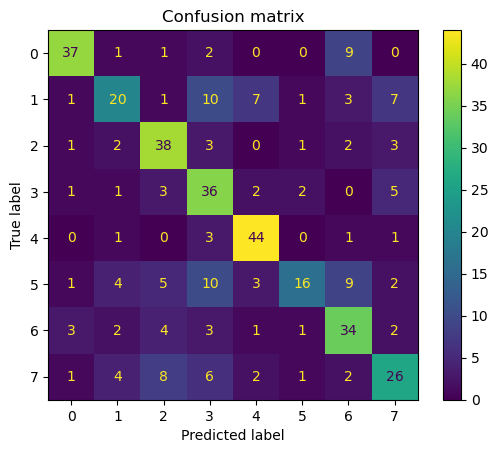

In [22]:
Y_pred = model.predict(X_test)
c = confusion_matrix(Y_test, np.argmax(Y_pred, axis=1))
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()

## c) Try to get better.

Ideas: use dropout and other tricks to prevent overfitting. Try to learn some convulutional layers as well.

In [31]:
fc2 = base_model.output
fc2 = Flatten()(fc2)

#======== Model to play around and improve ==============================================
# Alex: - Tried adding dropouts, did nothing basically
fc2 = Dense(512, activation="relu", name="my_dense1")(fc2)
fc2 = Dropout(0.2, name="my_dropout1")(fc2)
fc2 = Dense(512, activation="relu", name="my_dense2")(fc2)
fc2 = Dropout(0.2, name="my_dropout2")(fc2)
fc2 = Dense(100, activation="relu", name="my_dense3")(fc2)
fc2 = Dropout(0.2, name="my_dropout3")(fc2)

fc2 = Dense(8,activation='softmax', name='my_dense4')(fc2)
model_better = tf.compat.v1.keras.Model(base_model.input, fc2) #Current hack for TF 2.0 and keras
model_better.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [32]:
# Just as above
for layer in model_better.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False

my_dense1
my_dropout1
my_dense2
my_dropout2
my_dense3
my_dropout3
my_dense4


In [33]:
# Compile improved model
model_better.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# Train

# Create an ImageDataGenerator for data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.1,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# history_better = model_better.fit(
#    datagen.flow(X_train, Y_train, batch_size=100),
#    epochs=10,
#    validation_data=(X_valid, Y_valid)
# )
history_better = model_better.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
63/63 [==============================] - 40s 577ms/step - loss: 1.8876 - accuracy: 0.2745 - val_loss: 1.5689 - val_accuracy: 0.4575
Epoch 2/10
63/63 [==============================] - 36s 577ms/step - loss: 1.4778 - accuracy: 0.4550 - val_loss: 1.3452 - val_accuracy: 0.5350
Epoch 3/10
63/63 [==============================] - 37s 585ms/step - loss: 1.2783 - accuracy: 0.5415 - val_loss: 1.3141 - val_accuracy: 0.5075
Epoch 4/10
63/63 [==============================] - 35s 554ms/step - loss: 1.1074 - accuracy: 0.6150 - val_loss: 1.2459 - val_accuracy: 0.5525
Epoch 5/10
63/63 [==============================] - 44s 707ms/step - loss: 0.9694 - accuracy: 0.6545 - val_loss: 1.2542 - val_accuracy: 0.5675
Epoch 6/10
63/63 [==============================] - 47s 755ms/step - loss: 0.8290 - accuracy: 0.7150 - val_loss: 1.2501 - val_accuracy: 0.5800
Epoch 7/10
63/63 [==============================] - 49s 775ms/step - loss: 0.7065 - accuracy: 0.7570 - val_loss: 1.2685 - val_accuracy: 0.5800

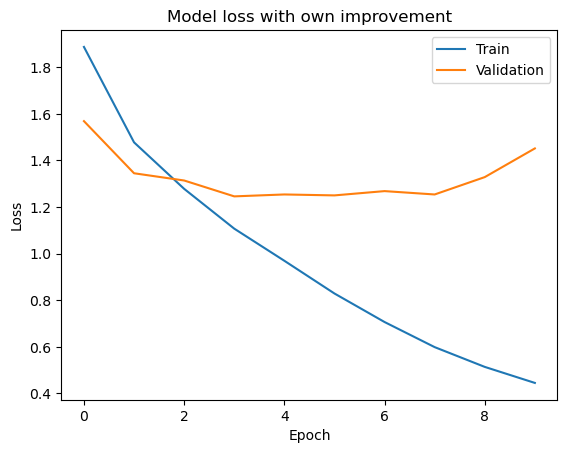

In [35]:
plt.plot(history_better.history['loss'], label='Train')
plt.plot(history_better.history['val_loss'], label='Validation')
plt.title('Model loss with own improvement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

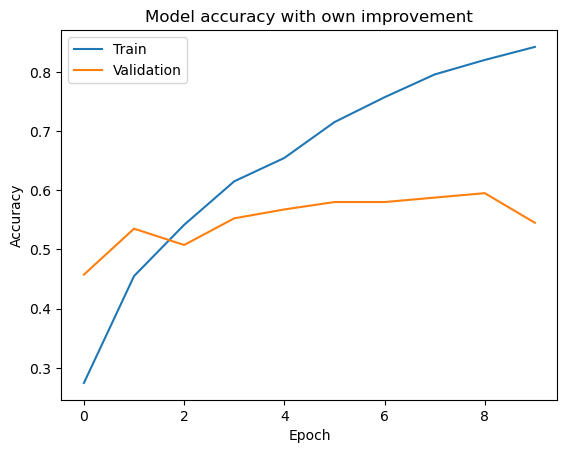

In [36]:
plt.plot(history_better.history['accuracy'], label='Train')
plt.plot(history_better.history['val_accuracy'], label='Validation')
plt.title('Model accuracy with own improvement')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Evaluate the model on the test set to get loss and accuracy
loss, accuracy = model_better.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 6s 430ms/step - loss: 1.2947 - accuracy: 0.5825
Test Loss: 1.2946538925170898
Test Accuracy: 0.5824999809265137


13/13 [==============================] - 0s 22ms/step


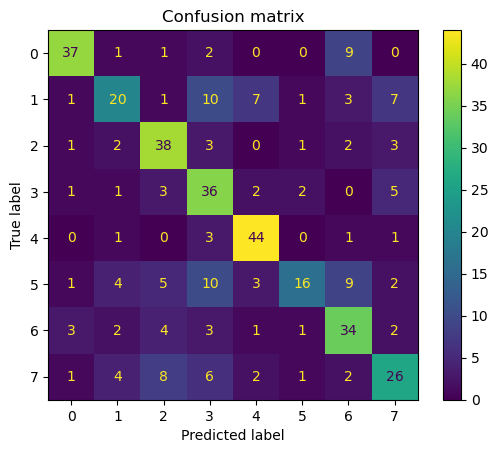

In [38]:
Y_pred = model.predict(X_test)
c = confusion_matrix(Y_test, np.argmax(Y_pred, axis=1))
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.title('Confusion matrix')
plt.show()